# NB04: Cross-Species Respiratory Chain Architecture

**Project**: Condition-Specific Respiratory Chain Wiring in ADP1

**Goal**: Test whether the Complex I/aromatic dependency correlates with respiratory chain architecture across Fitness Browser organisms. Do organisms with aromatic fitness data show Complex I defects on aromatics? Does NDH-2 presence/absence predict Complex I dispensability?

**Requires**: BERDL Spark access (on-cluster JupyterHub or local Spark Connect)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'

# Get Spark session — on BERDL JupyterHub, no import needed
spark = get_spark_session()
print(f'Spark session active: {spark.version}')

Spark session active: 4.0.1


## 1. Find Aromatic Experiments in the Fitness Browser

In [2]:
# Search experiment table for aromatic substrate conditions
aromatic_keywords = [
    'benzoate', '4-hydroxybenzoate', 'hydroxybenzoic', 'protocatechuate',
    'vanillin', 'vanillate', 'quinate', 'catechol', 'aromatic',
    'phenol', 'coumarate', 'ferulate', 'lignin'
]

# Build LIKE clauses
like_clauses = ' OR '.join([f"LOWER(condition_1) LIKE '%{kw}%'" for kw in aromatic_keywords])

aromatic_exps = spark.sql(f"""
    SELECT orgId, expName, expDesc, expGroup, condition_1, concentration_1, units_1
    FROM kescience_fitnessbrowser.experiment
    WHERE {like_clauses}
    ORDER BY orgId, expName
""").toPandas()

print(f'Aromatic experiments found: {len(aromatic_exps)}')
print(f'Organisms with aromatic experiments: {aromatic_exps["orgId"].nunique()}')
print()
print('=== Organisms × Aromatic Conditions ===')
org_cond = aromatic_exps.groupby('orgId')['condition_1'].apply(lambda x: ', '.join(x.unique())).reset_index()
for _, row in org_cond.iterrows():
    print(f'  {row["orgId"]:20s} {row["condition_1"][:70]}')

Aromatic experiments found: 33
Organisms with aromatic experiments: 16

=== Organisms × Aromatic Conditions ===
  ANA3                 Vanillin
  Cup4G11              4-Hydroxybenzoic Acid
  Kang                 Vanillin
  Keio                 Vanillin
  Korea                Vanillin
  MR1                  Vanillin
  Marino               Vanillin
  Miya                 Vanillin
  PV4                  Vanillin
  Phaeo                Vanillin
  Putida               Vanillin, 4-Hydroxybenzoic Acid
  SB2B                 Vanillin
  psRCH2               Vanillin
  pseudo3_N2E3         Vanillin
  pseudo5_N2C3_1       Vanillin
  pseudo6_N2E2         4-Hydroxybenzoic Acid


## 2. Identify Complex I (nuo) and NDH-2 (ndh) Genes in FB Organisms

In [3]:
# Get organisms that have aromatic experiments
aromatic_orgs = aromatic_exps['orgId'].unique().tolist()
org_list = "', '".join(aromatic_orgs)

# Find Complex I (nuo) genes in these organisms
nuo_genes = spark.sql(f"""
    SELECT orgId, locusId, sysName, gene, desc
    FROM kescience_fitnessbrowser.gene
    WHERE orgId IN ('{org_list}')
    AND type = '1'
    AND (LOWER(desc) LIKE '%nadh%ubiquinone%'
         OR LOWER(desc) LIKE '%nadh dehydrogenase%subunit%'
         OR LOWER(desc) LIKE '%nadh-quinone oxidoreductase%subunit%'
         OR gene LIKE 'nuo%')
""").toPandas()

print(f'Complex I (nuo) genes found: {len(nuo_genes)}')
print(f'Organisms with nuo genes: {nuo_genes["orgId"].nunique()}')

# Find NDH-2 genes — use text matching then FILTER to organisms with 1-2 hits
# True NDH-2 is a single-subunit enzyme; organisms with >2 hits likely have
# misannotated Complex I subunits leaking through
ndh2_raw = spark.sql(f"""
    SELECT orgId, locusId, sysName, gene, desc
    FROM kescience_fitnessbrowser.gene
    WHERE orgId IN ('{org_list}')
    AND type = '1'
    AND (LOWER(desc) LIKE '%nadh dehydrogenase%'
         OR LOWER(desc) LIKE '%type ii nadh%'
         OR LOWER(desc) LIKE '%ndh-2%'
         OR gene = 'ndh')
    AND LOWER(desc) NOT LIKE '%subunit%'
    AND LOWER(desc) NOT LIKE '%chain%'
    AND LOWER(desc) NOT LIKE '%ubiquinone%'
""").toPandas()

print(f'\nNDH-2 raw candidates: {len(ndh2_raw)}')

# Count hits per organism
ndh2_counts = ndh2_raw.groupby('orgId').size()
print(f'\nHits per organism (before filtering):')
for org, count in ndh2_counts.items():
    flag = ' <-- likely Complex I leakage' if count > 2 else ''
    print(f'  {org:20s} {count:>2} hits{flag}')

# Filter: keep only organisms with 1-2 NDH-2 hits (true single-subunit NDH-2)
valid_ndh2_orgs = ndh2_counts[ndh2_counts <= 2].index.tolist()
ndh2_genes = ndh2_raw[ndh2_raw['orgId'].isin(valid_ndh2_orgs)]

print(f'\nAfter filtering (<=2 hits per organism):')
print(f'NDH-2 genes retained: {len(ndh2_genes)}')
print(f'Organisms with validated NDH-2: {ndh2_genes["orgId"].nunique()}')
print(f'Organisms excluded (>2 hits): {len(ndh2_counts) - len(valid_ndh2_orgs)}')

if len(ndh2_genes) > 0:
    print(f'\n=== Validated NDH-2 Genes ===')
    for _, row in ndh2_genes.iterrows():
        print(f'  {row["orgId"]:20s} {row["locusId"]:20s} {str(row["desc"])[:50]}')

Complex I (nuo) genes found: 180
Organisms with nuo genes: 14



NDH-2 raw candidates: 36

Hits per organism (before filtering):
  Cup4G11               4 hits <-- likely Complex I leakage
  Keio                  1 hits
  MR1                   1 hits
  Marino                1 hits
  Miya                  6 hits <-- likely Complex I leakage
  PV4                   2 hits
  Putida                1 hits
  SB2B                  1 hits
  pseudo3_N2E3          8 hits <-- likely Complex I leakage
  pseudo5_N2C3_1        8 hits <-- likely Complex I leakage
  pseudo6_N2E2          3 hits <-- likely Complex I leakage

After filtering (<=2 hits per organism):
NDH-2 genes retained: 7
Organisms with validated NDH-2: 6
Organisms excluded (>2 hits): 5

=== Validated NDH-2 Genes ===
  SB2B                 6936749              NADH dehydrogenase (RefSeq)
  Keio                 15231                respiratory NADH dehydrogenase 2/cupric reductase 
  Marino               GFF4233              NADH dehydrogenase (quinone)
  MR1                  202618               NA

## 3. Complex I Fitness on Aromatic vs Non-Aromatic Conditions

In [4]:
# For each organism with aromatic experiments, get Complex I fitness
# on aromatic AND non-aromatic experiments

results = []

for org in aromatic_orgs:
    # Get aromatic experiment names for this organism
    org_arom_exps = aromatic_exps[aromatic_exps['orgId'] == org]['expName'].tolist()
    if not org_arom_exps:
        continue
    
    # Get nuo genes for this organism
    org_nuo = nuo_genes[nuo_genes['orgId'] == org]['locusId'].tolist()
    if not org_nuo:
        continue
    
    nuo_list = "', '".join(org_nuo)
    arom_exp_list = "', '".join(org_arom_exps)
    
    # Get fitness for nuo genes on ALL experiments
    try:
        nuo_fitness = spark.sql(f"""
            SELECT locusId, expName, CAST(fit AS FLOAT) as fit, CAST(t AS FLOAT) as t
            FROM kescience_fitnessbrowser.genefitness
            WHERE orgId = '{org}'
            AND locusId IN ('{nuo_list}')
        """).toPandas()
        
        if len(nuo_fitness) == 0:
            continue
        
        # Mark aromatic vs non-aromatic experiments
        nuo_fitness['is_aromatic'] = nuo_fitness['expName'].isin(org_arom_exps)
        
        # Compute mean fitness
        arom_fit = nuo_fitness[nuo_fitness['is_aromatic']]['fit'].mean()
        non_arom_fit = nuo_fitness[~nuo_fitness['is_aromatic']]['fit'].mean()
        n_arom = nuo_fitness[nuo_fitness['is_aromatic']].shape[0]
        n_non_arom = nuo_fitness[~nuo_fitness['is_aromatic']].shape[0]
        
        has_ndh2 = org in ndh2_genes['orgId'].values
        
        results.append({
            'orgId': org,
            'n_nuo_genes': len(org_nuo),
            'has_ndh2': has_ndh2,
            'aromatic_fitness': arom_fit,
            'non_aromatic_fitness': non_arom_fit,
            'aromatic_deficit': arom_fit - non_arom_fit,
            'n_aromatic_entries': n_arom,
            'n_non_aromatic_entries': n_non_arom,
            'aromatic_conditions': ', '.join(aromatic_exps[aromatic_exps['orgId']==org]['condition_1'].unique())
        })
        
    except Exception as e:
        print(f'  Error for {org}: {e}')

df_results = pd.DataFrame(results)
print(f'Organisms with Complete I aromatic fitness data: {len(df_results)}')

if len(df_results) > 0:
    print(f'\n=== Complex I Aromatic Fitness by Organism ===')
    print(f'{"Organism":20s} {"NDH-2":>5s} {"Arom fit":>9s} {"Non-arom":>9s} {"Deficit":>8s} {"Conditions"}')
    print('-' * 90)
    for _, row in df_results.sort_values('aromatic_deficit').iterrows():
        ndh2_str = 'Yes' if row['has_ndh2'] else 'No'
        print(f'{row["orgId"]:20s} {ndh2_str:>5s} {row["aromatic_fitness"]:>9.3f} '
              f'{row["non_aromatic_fitness"]:>9.3f} {row["aromatic_deficit"]:>+8.3f} '
              f'{row["aromatic_conditions"][:30]}')

Organisms with Complete I aromatic fitness data: 14

=== Complex I Aromatic Fitness by Organism ===
Organism             NDH-2  Arom fit  Non-arom  Deficit Conditions
------------------------------------------------------------------------------------------
Kang                    No    -0.161     1.125   -1.286 Vanillin
Putida                 Yes    -1.536    -0.603   -0.933 Vanillin, 4-Hydroxybenzoic Aci
psRCH2                  No    -0.991    -0.223   -0.768 Vanillin
Keio                   Yes    -0.944    -0.507   -0.436 Vanillin
MR1                    Yes    -0.568    -0.334   -0.235 Vanillin
pseudo5_N2C3_1          No    -0.077     0.001   -0.077 Vanillin
Korea                   No    -0.230    -0.183   -0.047 Vanillin
Marino                 Yes    -0.173    -0.152   -0.021 Vanillin
Cup4G11                 No     0.015    -0.044   +0.059 4-Hydroxybenzoic Acid
Phaeo                   No     0.151     0.072   +0.079 Vanillin
pseudo6_N2E2            No     0.065    -0.020   +0.085 4

## 4. NDH-2 Presence vs Complex I Essentiality

=== NDH-2 Presence vs Complex I Aromatic Deficit ===
Organisms WITH NDH-2:    n= 5  mean deficit=-0.297
Organisms WITHOUT NDH-2: n= 9  mean deficit=-0.156

Mann-Whitney U test: U=17, p=0.5185


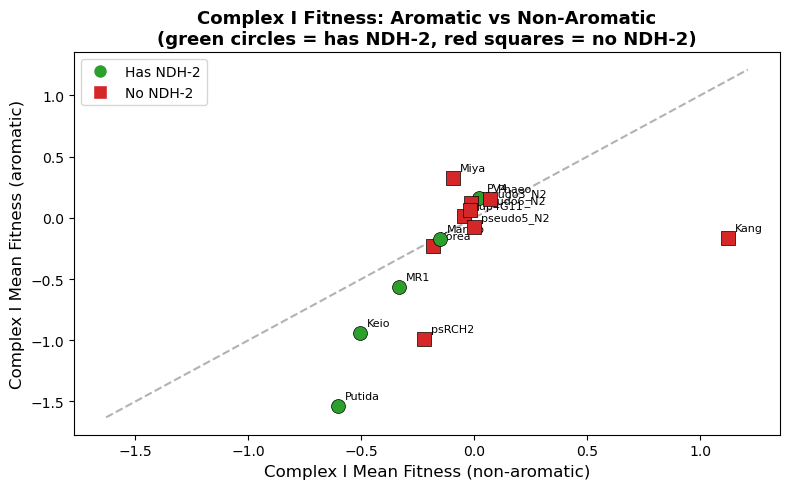

Saved: figures/ndh2_vs_complex_I.png


In [5]:
# Test: do organisms WITH NDH-2 show smaller Complex I aromatic deficits
# (because NDH-2 can partially compensate)?

if len(df_results) >= 3:
    with_ndh2 = df_results[df_results['has_ndh2']]
    without_ndh2 = df_results[~df_results['has_ndh2']]
    
    print('=== NDH-2 Presence vs Complex I Aromatic Deficit ===')
    print(f'Organisms WITH NDH-2:    n={len(with_ndh2):>2}  mean deficit={with_ndh2["aromatic_deficit"].mean():+.3f}')
    print(f'Organisms WITHOUT NDH-2: n={len(without_ndh2):>2}  mean deficit={without_ndh2["aromatic_deficit"].mean():+.3f}')
    print()
    
    if len(with_ndh2) >= 2 and len(without_ndh2) >= 2:
        from scipy.stats import mannwhitneyu
        stat, p = mannwhitneyu(with_ndh2['aromatic_deficit'], without_ndh2['aromatic_deficit'],
                              alternative='two-sided')
        print(f'Mann-Whitney U test: U={stat:.0f}, p={p:.4f}')
    else:
        print('Too few organisms for statistical test')
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    
    for _, row in df_results.iterrows():
        color = '#2ca02c' if row['has_ndh2'] else '#d62728'
        marker = 'o' if row['has_ndh2'] else 's'
        ax.scatter(row['non_aromatic_fitness'], row['aromatic_fitness'],
                  c=color, marker=marker, s=100, edgecolors='black', linewidth=0.5, zorder=5)
        ax.annotate(row['orgId'][:10], (row['non_aromatic_fitness'], row['aromatic_fitness']),
                   textcoords='offset points', xytext=(5, 5), fontsize=8)
    
    # Diagonal line (equal fitness)
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'k--', alpha=0.3, label='Equal fitness')
    
    ax.set_xlabel('Complex I Mean Fitness (non-aromatic)', fontsize=12)
    ax.set_ylabel('Complex I Mean Fitness (aromatic)', fontsize=12)
    ax.set_title('Complex I Fitness: Aromatic vs Non-Aromatic\n'
                 '(green circles = has NDH-2, red squares = no NDH-2)',
                 fontsize=13, fontweight='bold')
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Has NDH-2'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#d62728', markersize=10, label='No NDH-2')
    ]
    ax.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'ndh2_vs_complex_I.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: figures/ndh2_vs_complex_I.png')
else:
    print('Too few organisms with data for NDH-2 comparison')

## 5. Summary

In [6]:
# Save results
if len(df_results) > 0:
    df_results.to_csv(os.path.join(DATA_DIR, 'cross_species_respiratory.csv'), index=False)
    print(f'Saved: data/cross_species_respiratory.csv ({len(df_results)} organisms)')

aromatic_exps.to_csv(os.path.join(DATA_DIR, 'fb_aromatic_experiments.csv'), index=False)
print(f'Saved: data/fb_aromatic_experiments.csv ({len(aromatic_exps)} experiments)')

print(f'\n=== NB04 Summary ===')
print(f'FB aromatic experiments: {len(aromatic_exps)}')
print(f'Organisms with aromatic data: {len(aromatic_orgs)}')
print(f'Organisms with Complex I + aromatic fitness: {len(df_results)}')
if len(df_results) > 0:
    mean_deficit = df_results['aromatic_deficit'].mean()
    print(f'Mean Complex I aromatic deficit: {mean_deficit:+.3f}')
    print(f'Organisms with NDH-2: {df_results["has_ndh2"].sum()} / {len(df_results)}')

Saved: data/cross_species_respiratory.csv (14 organisms)
Saved: data/fb_aromatic_experiments.csv (33 experiments)

=== NB04 Summary ===
FB aromatic experiments: 33
Organisms with aromatic data: 16
Organisms with Complex I + aromatic fitness: 14
Mean Complex I aromatic deficit: -0.206
Organisms with NDH-2: 5 / 14
